In [1]:
import os
import requests
import base64

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Configuration
GPT4V_KEY = "6b9d488c317d4babb35cb2c6f23ed242"

prompt_template = """
You are an AI Agent whose goal is to describe tasks to perform to another AI capable of executing actions by writing Playwright code.
To do so, you are given a screenshot and objectives.
You must provide your answer inside a markdown, with the form 'Select element X, then do Y'.
Leverage as much information from the screenshot to make it easy to identify the element, such as placeholders or text.
Do not make assumptions about elements you do not see.

Here are previous examples:
---
Objective: Click on $50 to $100 price range filter
Output:
Let's think step by step.
This is a screenshot of an e-commerce website.
 
Given the screenshot, the option '$50 to $100' is a radio button. It is under the 'Price' section, which might be helpful to identify the element.
Therefore the instructions are:
```
- Select the radio button '$50 to $100' under Price, then click on it.
```
---
Objective: Click on 'Datasets'
Output:
Let's think step by step.
 
Given the screenshot, 'Datasets' seems to be a button on the menu. Nearby elements on the menu are called 'Models' and 'Spaces'.
Therefore the instructions are:
```
- Select the 'Datasets' element on the menu next to 'Models' and 'Spaces', then click on it.
```
---
---
Objective: Write 'Hello world' in the search bar
Output:
Let's think step by step.
 
Given the screenshot, the search bar has a placeholder 'Search here...'. 
Therefore the instructions are:
```
- Select the input element with placeholder 'Search here...', then type 'Hello world'.
```
---

Objective: {objective}
Output:
Let's think step by step.
"""

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os.path

chrome_options = Options()
chrome_options.add_argument("--headless")  # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--window-size=1600,900")

homedir = os.path.expanduser("~")

# Paths to the chromedriver files
path_linux = f"{homedir}/chromedriver-linux64/chromedriver"
path_testing = f"{homedir}/chromedriver-testing/chromedriver"
path_mac = (
    "Google Chrome for Testing.app/Contents/MacOS/Google Chrome for Testing"
)

# To avoid breaking change kept legacy linux64 path
if os.path.exists(path_linux):
    chrome_options.binary_location = f"{homedir}/chrome-linux64/chrome"
    webdriver_service = Service(f"{homedir}/chromedriver-linux64/chromedriver")
elif os.path.exists(path_testing):
    if os.path.exists(f"{homedir}/chrome-testing/{path_mac}"):
        chrome_options.binary_location = f"{homedir}/chrome-testing/{path_mac}"
    # Can add support here for other chrome binaries with else if statements
    webdriver_service = Service(f"{homedir}/chromedriver-testing/chromedriver")
else:
    raise FileNotFoundError("Neither chromedriver file exists.")

driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)
import os
from llama_index.llms.azure_openai import AzureOpenAI
from lavague.retrievers import BM25HtmlRetriever, OpsmSplitRetriever
from lavague.defaults import DefaultEmbedder

# api_key=os.getenv("AZURE_OPENAI_KEY")
# api_version="2024-02-15-preview"
# azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
# model = "gpt-35-turbo"
# deployment_name = "gpt-35-turbo"

# from llama_index.llms.azure_openai import AzureOpenAI
# import os

api_key=os.getenv("AZURE_OPENAI_KEY")
api_version="2023-05-15"
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model = "gpt-4"
deployment_name = "gpt-4-turbo"

llm = AzureOpenAI(
    model=model,
    deployment_name=deployment_name,
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
    temperature=0.0
)

embedder = DefaultEmbedder()
bm25_retriever = BM25HtmlRetriever(embedder)
opsm_retriever = OpsmSplitRetriever(embedder)
from lavague.action_engine import ActionEngine

opsm_retriever = OpsmSplitRetriever(embedder)
action_engine = ActionEngine(llm, bm25_retriever)

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
import re

def extract_instructions_from_markdown(markdown_text):
    code_blocks = re.findall(r'```(?:\w+)?\n(.*?)\n```', markdown_text, re.DOTALL)
    instructions = []
    for code_block in code_blocks:
        instructions.extend(re.findall(r'^\s*-\s*(.*?)\s*$', code_block, re.MULTILINE))
    return instructions
def get_instructions(driver, objective):
    headers = {
        "Content-Type": "application/json",
        "api-key": GPT4V_KEY,
    }
    driver.save_screenshot("screenshot.png")
    image_path = "screenshot.png"

    # Getting the base64 string
    base64_image = encode_image(image_path)

    prompt = prompt_template.format(objective=objective)

    # Payload for the request
    payload = {
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }
            }
        ]
        }
    ],
    "temperature": 0.7,
    "top_p": 0.95,
    "max_tokens": 800
    }

    GPT4V_ENDPOINT = "https://mith-oai-west.openai.azure.com/openai/deployments/gpt-4-vision/chat/completions?api-version=2023-07-01-preview"

    # Send request
    try:
        response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
        response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
    except requests.RequestException as e:
        raise SystemExit(f"Failed to make the request. Error: {e}")

    output = response.json()["choices"][0]["message"]["content"]
    instruction = extract_instructions_from_markdown(output) 
    return instruction

def execute_instructions(driver, action_engine, query):

    html = driver.page_source

    action = action_engine.get_action(query, html)
    exec(action)

    driver.save_screenshot("screenshot.png")

    from IPython.display import Image, display
    display(Image("screenshot.png"))


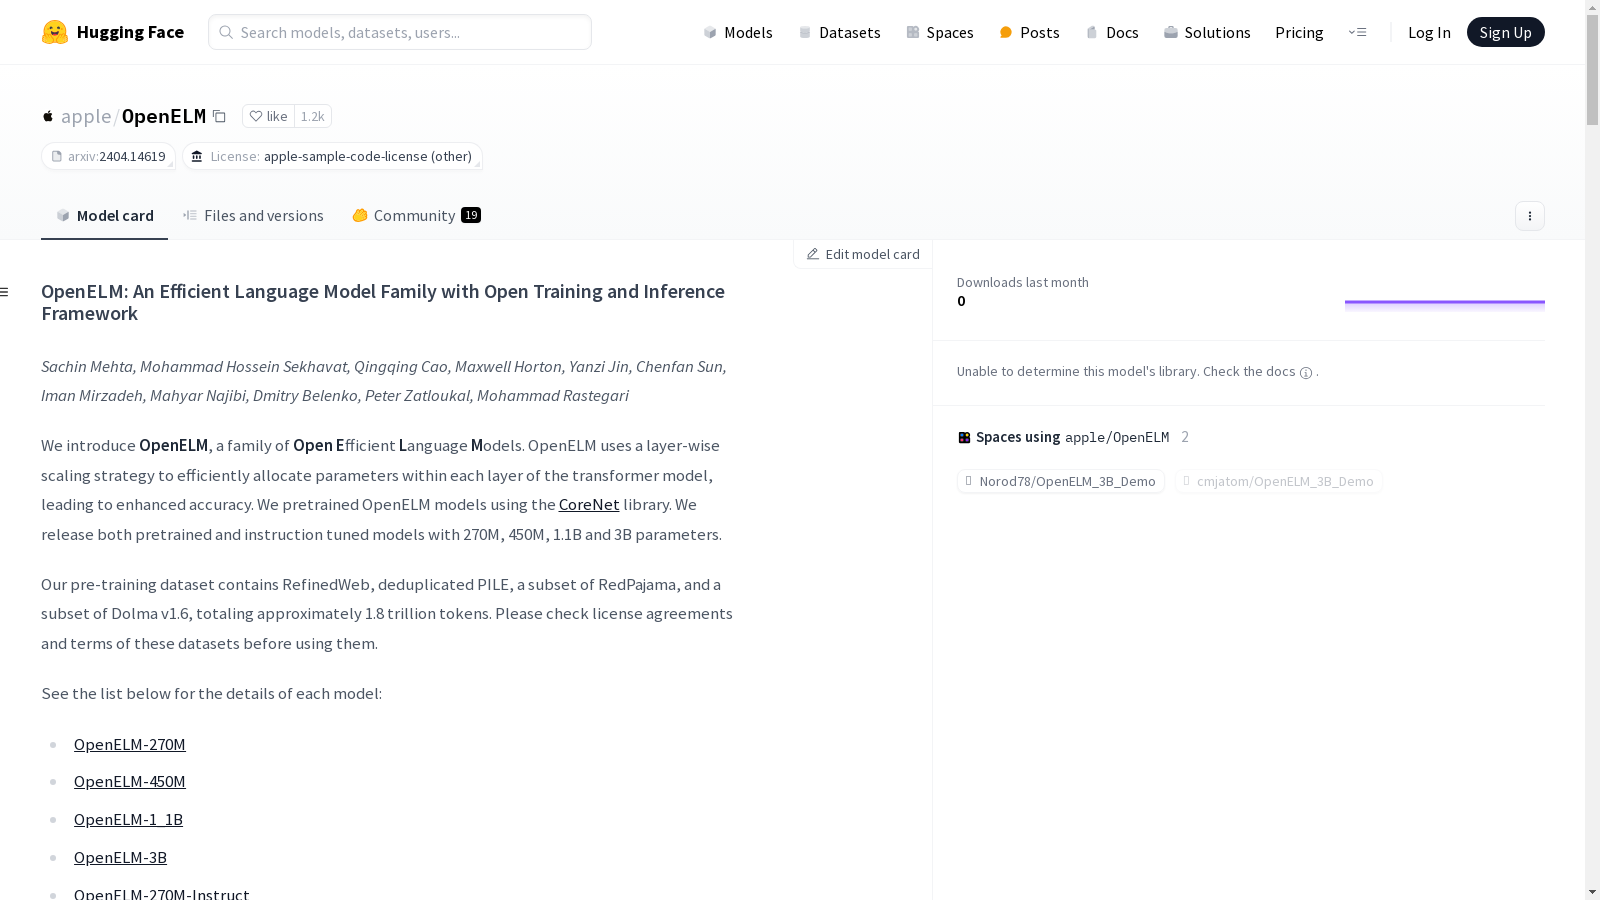

In [4]:
driver.get("https://huggingface.co/apple/OpenELM")
driver.save_screenshot("screenshot.png")

from IPython.display import Image, display
display(Image("screenshot.png"))

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


# Let's proceed step by step.
# First we need to identify the section with the text 'OpenELM: An efficient language model family', then we can extract the text.

# Based on the HTML provided, we need to find the element that contains the text.
# We can use the title attribute to precisely target the element.
openelm_section = driver.find_element(By.XPATH, """//*[contains(@title,"OpenELM: An Efficient Language Model Family with Open Training and Inference Framework")]""")

# Now we can print the text of the element found.
print(openelm_section.text)



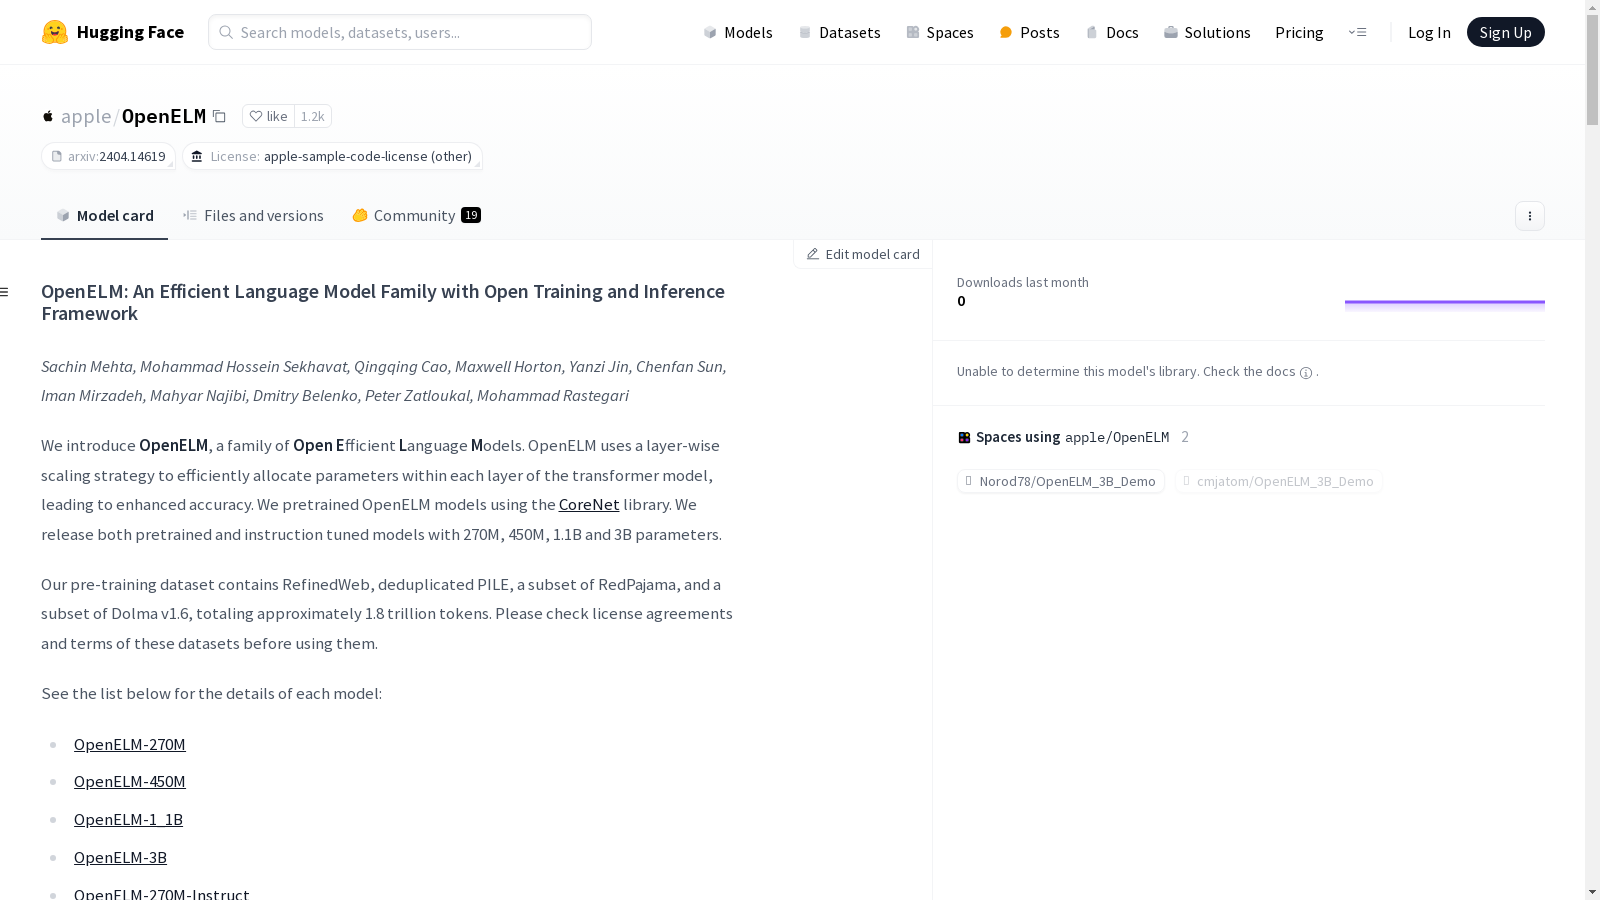

In [5]:
query = "Print all the text under the section 'OpenELM: An efficient language model family'"
html = driver.page_source

action = action_engine.get_action(query, html)
print(action)
exec(action)

driver.save_screenshot("screenshot.png")

from IPython.display import Image, display
display(Image("screenshot.png"))

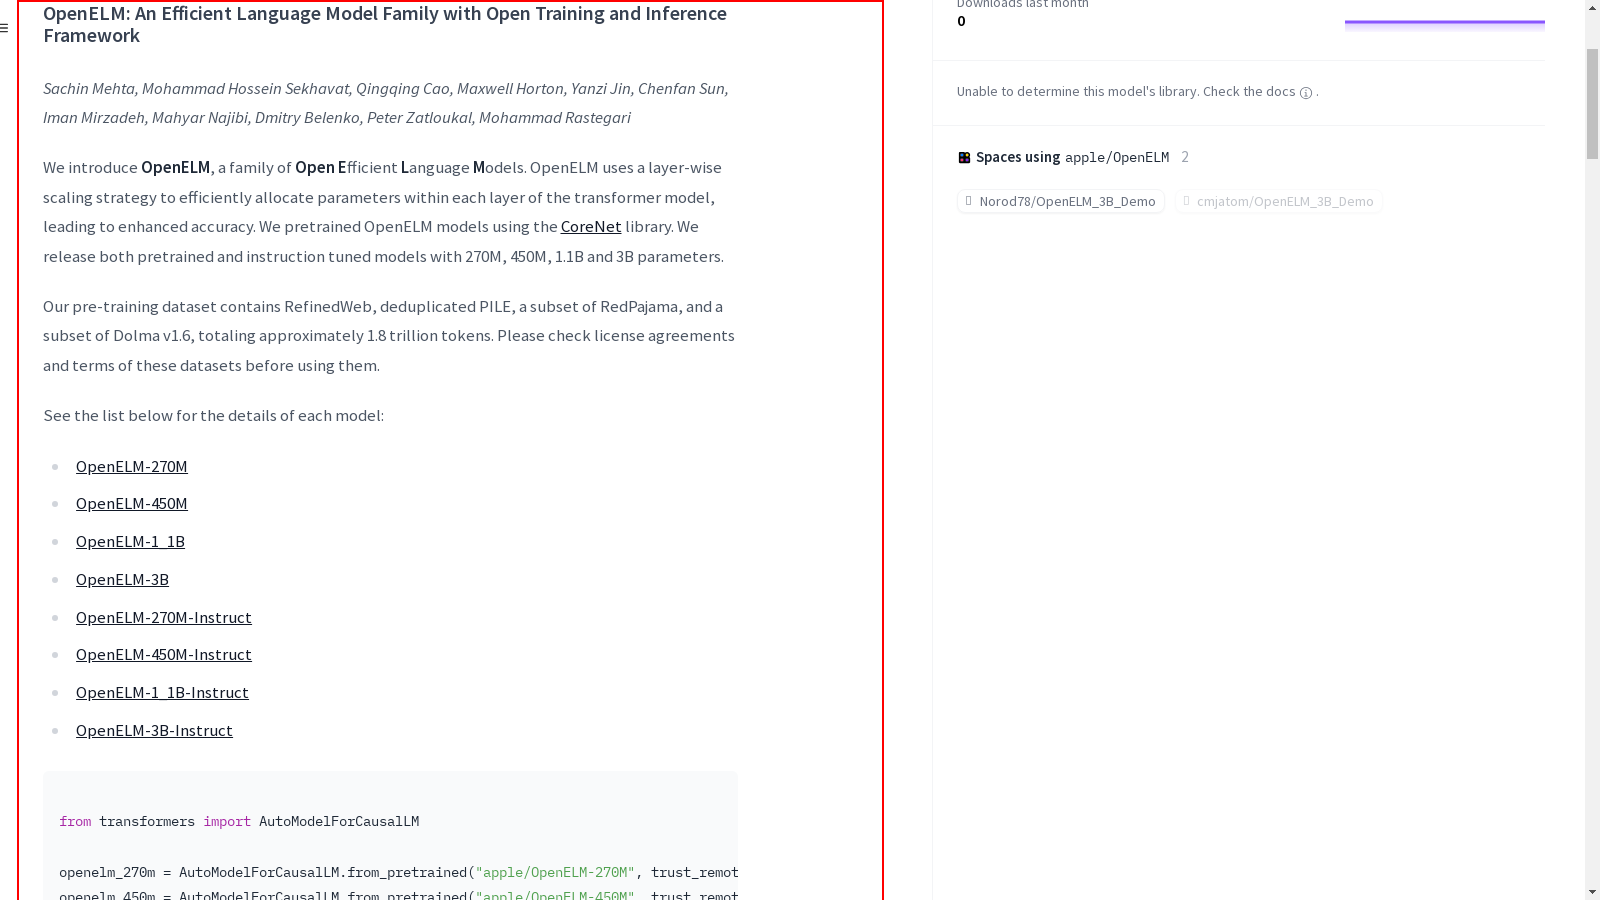

In [22]:
from IPython.display import Image, display
from selenium import webdriver

def highlight_element(driver, element):
    # Apply style to the element
    driver.execute_script("arguments[0].setAttribute('style', arguments[1]);", element, "border: 2px solid red;")
    
    # Take a screenshot
    screenshot_path = './screenshot.png'  # Update path as necessary
    driver.save_screenshot(screenshot_path)
    
    # Display the screenshot
    display(Image(filename=screenshot_path))
    
    # Optionally, remove the style after taking the screenshot if you don't want it to persist
    driver.execute_script("arguments[0].setAttribute('style', arguments[1]);", element, "")

highlight_element(driver, ground_truth_element)

In [6]:

# Let's proceed step by step.
# First we need to identify the section with the text 'OpenELM: An efficient language model family', then we can extract the text.

# Based on the HTML provided, we need to find the element that contains the text.
# We can use the title attribute to precisely target the element.
openelm_section = driver.find_element(By.XPATH, """//*[contains(@title,"OpenELM: An Efficient Language Model Family with Open Training and Inference Framework")]""")

# Now we can print the text of the element found.
print(openelm_section.text)



In [8]:
def get_bounding_box(element):
    location = element.location
    size = element.size

    # Coordinates
    x_coordinate = location['x']
    y_coordinate = location['y']

    # Size
    width = size['width']
    height = size['height']
    
    box = {
        "x": x_coordinate,
        "y": y_coordinate,
        "width": width,
        "height": height
    }

    return box


def display_bounding_box(element, driver):
    box = get_bounding_box(element)
    from PIL import Image, ImageDraw
    driver.execute_script("arguments[0].scrollIntoView(true);", element)

    driver.save_screenshot("page_screenshot.png")

    image = Image.open("page_screenshot.png")
    draw = ImageDraw.Draw(image)

# Calculate rectangle coordinates
    left = box['x']
    top = box['y']
    right = left + box['width']
    bottom = top + box['height']

    # Draw a rectangle around the element
    draw.rectangle([left, top, right, bottom], outline="red", width=2)

    # Save the modified image
    image.save("highlighted_element.png")

    from IPython.display import Image, display
    display(Image(filename="highlighted_element.png"))

In [10]:
from selenium.webdriver.common.by import By

def get_full_xpath(driver, element):
    parts = []
    while element.tag_name != 'html':
        parent = driver.execute_script('return arguments[0].parentNode;', element)
        siblings = parent.find_elements(By.XPATH, f"./*[name()='{element.tag_name}']")
        count = 0
        index = 1
        for sibling in siblings:
            count += 1
            if sibling == element:
                index = count
        parts.insert(0, f"{element.tag_name}[{index}]")
        element = parent
    parts.insert(0, 'html')  # assuming the root element is always <html>
    full_xpath = '/' + '/'.join(parts)
    return full_xpath

In [19]:
openelm_section.text

''

In [17]:
print(ground_truth_element.text)

OpenELM: An Efficient Language Model Family with Open Training and Inference Framework
Sachin Mehta, Mohammad Hossein Sekhavat, Qingqing Cao, Maxwell Horton, Yanzi Jin, Chenfan Sun, Iman Mirzadeh, Mahyar Najibi, Dmitry Belenko, Peter Zatloukal, Mohammad Rastegari
We introduce OpenELM, a family of Open Efficient Language Models. OpenELM uses a layer-wise scaling strategy to efficiently allocate parameters within each layer of the transformer model, leading to enhanced accuracy. We pretrained OpenELM models using the CoreNet library. We release both pretrained and instruction tuned models with 270M, 450M, 1.1B and 3B parameters.
Our pre-training dataset contains RefinedWeb, deduplicated PILE, a subset of RedPajama, and a subset of Dolma v1.6, totaling approximately 1.8 trillion tokens. Please check license agreements and terms of these datasets before using them.
See the list below for the details of each model:
OpenELM-270M
OpenELM-450M
OpenELM-1_1B
OpenELM-3B
OpenELM-270M-Instruct
Open

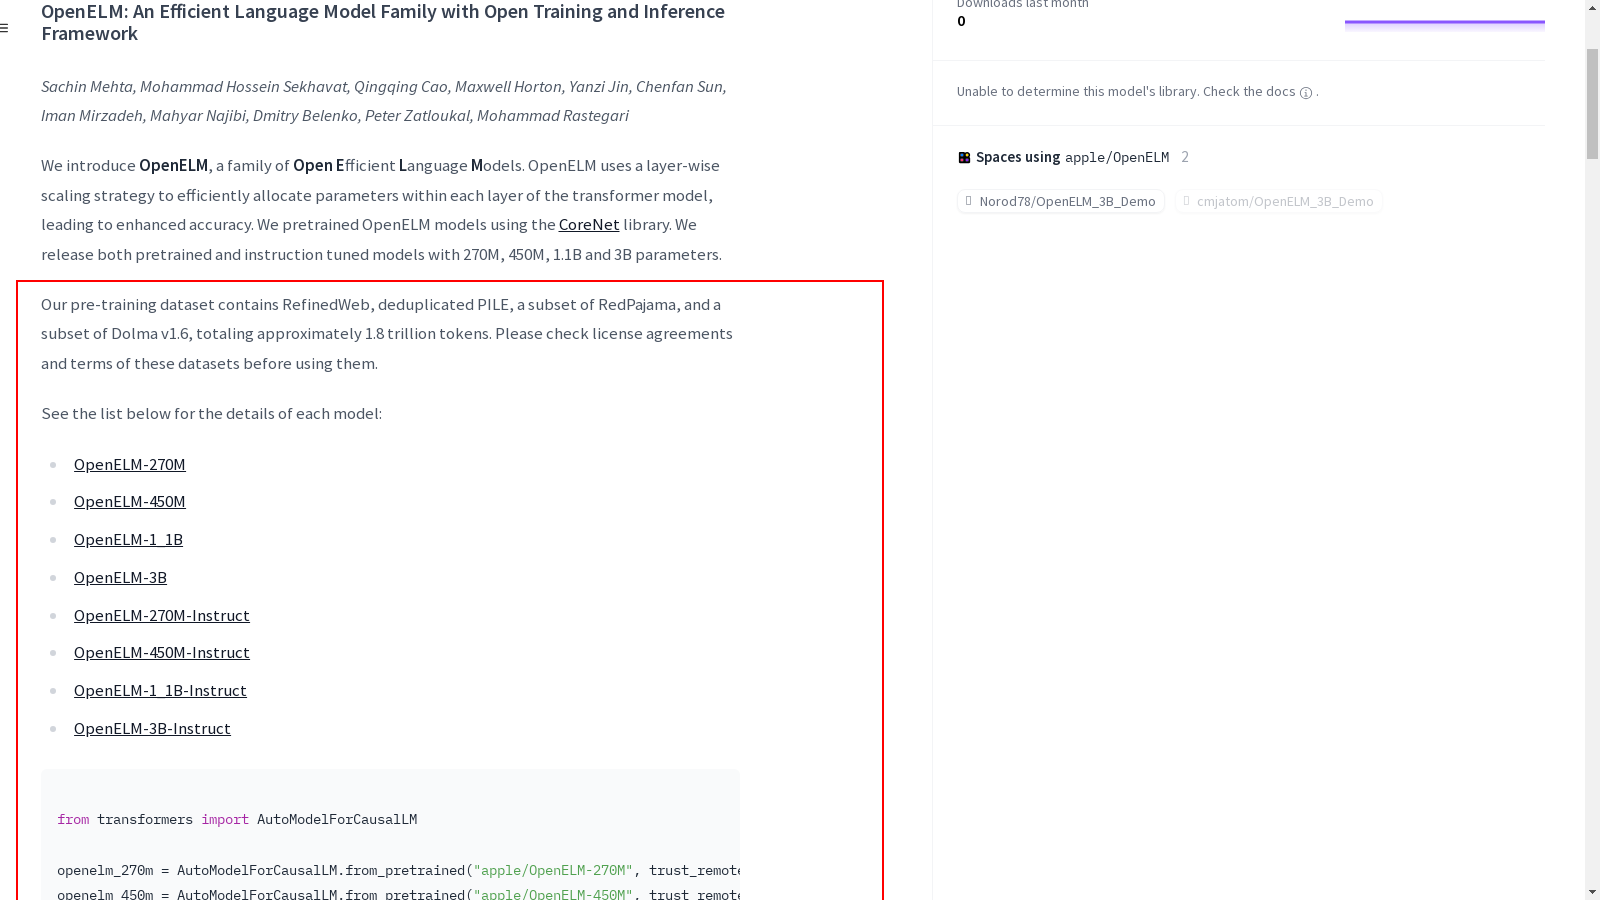

In [15]:
ground_truth_xpath = "/html/body/div[1]/main/div[2]/section[1]/div[3]/div[3]"
ground_truth_element = driver.find_element(By.XPATH, ground_truth_xpath)
display_bounding_box(ground_truth_element, driver)

In [11]:
get_full_xpath(driver, openelm_section)

'/html/body[1]/div[1]/main[1]/div[2]/section[1]/div[3]/div[1]/div[1]/div[1]/div[1]/div[1]/nav[1]/ul[1]/li[1]/a[1]'

In [24]:
driver.get("https://huggingface.co/CohereForAI/c4ai-command-r-plus")

In [27]:
objective = "Type 'What is love?' in the chat box"
expanded_instructions = get_instructions(driver, objective)[0]

In [33]:
expanded_instructions

"Select the input element with placeholder 'Your sentence here...' under the 'Inference API' section, then type 'What is love?'."

In [ ]:
expanded_instructions = "Select the input element with placeholder 'Your sentence here...' under the 'Inference API' section, then type 'What is love?' and press 'Enter'"

In [34]:
html = driver.page_source
expanded_instructions = "Select the input element with placeholder 'Your sentence here...' under the 'Inference API' section, then type 'What is love?' and press 'Enter'"

action = action_engine.get_action(expanded_instructions, html)

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [35]:
from selenium.webdriver.common.keys import Keys


In [38]:
# Let's proceed step by step.
# First we need to identify the input element with the placeholder 'Your sentence here...' under the 'Inference API' section.

# Based on the HTML snippet provided, we can identify the input element by its placeholder attribute.
# We will use the XPATH to locate the element precisely.
input_element = driver.find_element(By.XPATH, """//*[contains(@placeholder,"Your sentence here...")]""")

# Now that we have identified the input element, we can type the text 'What is love?' into it.
input_element.send_keys("What is love?")

input_element.send_keys(Keys.ENTER)

In [ ]:
input_element.send_keys(Keys.RETURN)

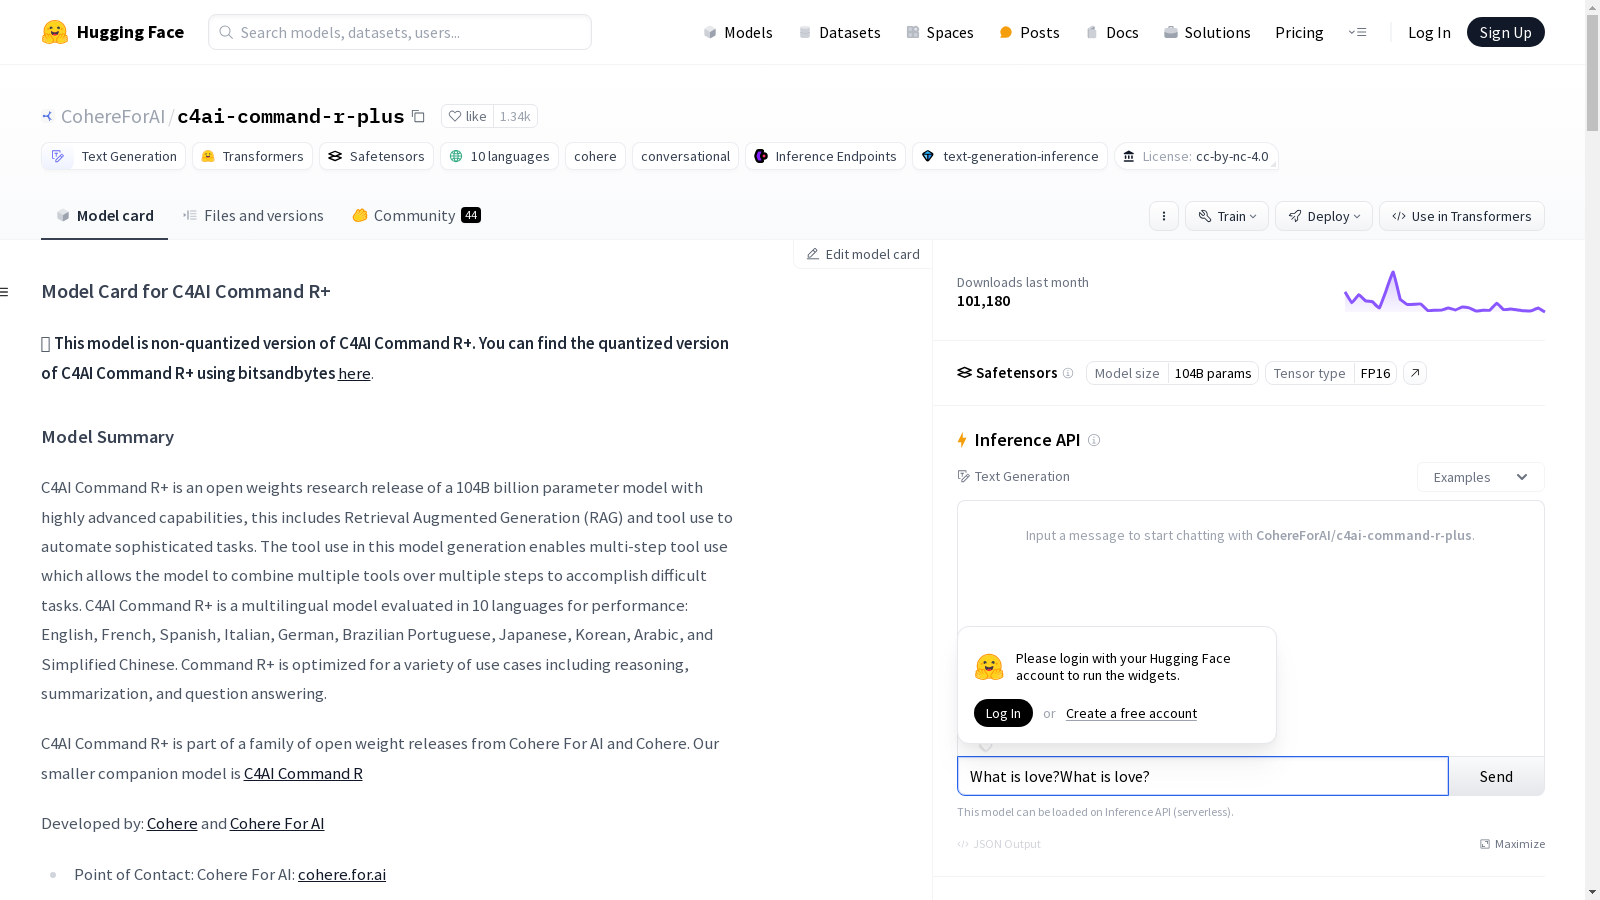

In [39]:
driver.save_screenshot("screenshot.png")
display(Image("screenshot.png"))

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


# Let's proceed step by step.
# First we need to identify the section with the text 'OpenELM: An efficient language model family', then we can extract the text.

# Based on the HTML provided, we need to find the element that contains the text.
# We can use the title attribute to precisely target the element.
openelm_section = driver.find_element(By.XPATH, """//*[contains(@title,"OpenELM: An Efficient Language Model Family with Open Training and Inference Framework")]""")

# Now we can print the text of the element found.
print(openelm_section.text)



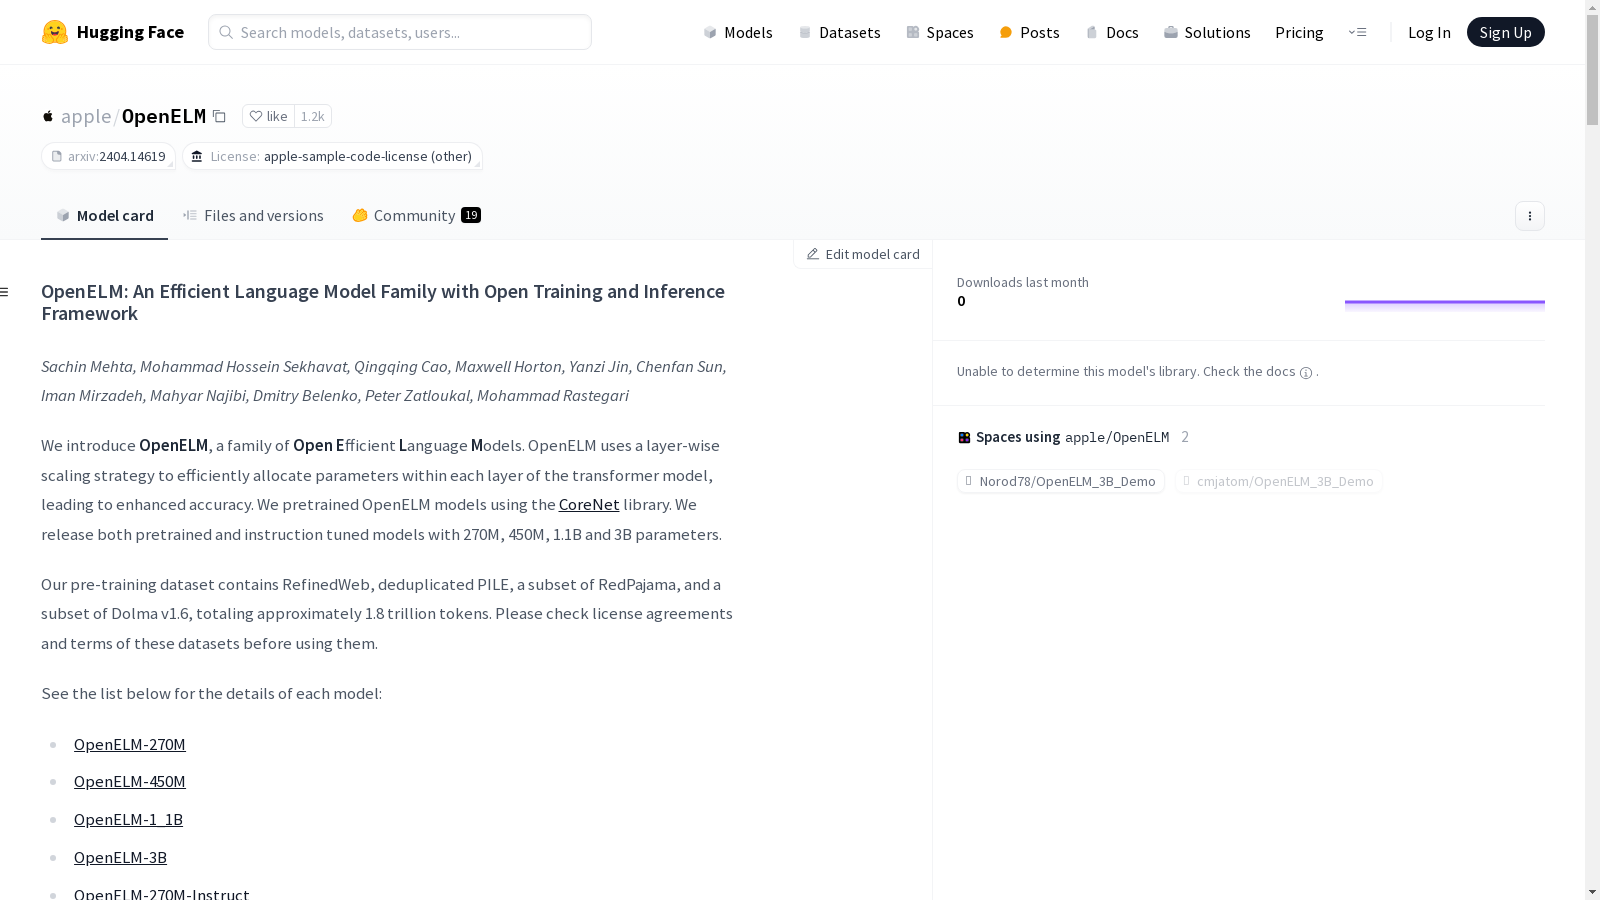

In [ ]:
query = "Print all the text under the section 'OpenELM: An efficient language model family'"
html = driver.page_source

action = action_engine.get_action(query, html)
print(action)
exec(action)

driver.save_screenshot("screenshot.png")

from IPython.display import Image, display
display(Image("screenshot.png"))

In [ ]:

objective = "Click on Submit"
expanded_instructions = get_instructions(driver, objective)[0]
execute_instructions(driver, action_engine, expanded_instructions)
objective = "Click on Datasets"

expanded_instructions = get_instructions(driver, objective)[0]

try: 
    execute_instructions(driver, action_engine, objective)
except Exception as e:
    print("Failed to execute instructions with raw instruction")
    print(e)

try:
    execute_instructions(driver, action_engine, expanded_instructions)
except:
    print("Failed to execute instructions with expanded instruction")
    print(e)
driver.get("https://huggingface.co/")

query = instruction[0]
html = driver.page_source

action = action_engine.get_action(query, html)
exec(action)

driver.save_screenshot("screenshot.png")

from IPython.display import Image, display
display(Image("screenshot.png"))
driver.get("https://huggingface.co/")

query = objective
html = driver.page_source

action = action_engine.get_action(query, html)
exec(action)

driver.save_screenshot("screenshot.png")

from IPython.display import Image, display
display(Image("screenshot.png"))
# Let's proceed step by step.
# First we need to identify the input element, then we can click on it and type the required text.

# Based on the HTML provided, we can identify the input element by its placeholder attribute.
search_input = driver.find_element(By.XPATH, """//*[contains(@placeholder,"Search models, datasets, users...")]""")

# Click on the input element to focus on it
search_input.click()

# Now we can type 'Llama3' into the input element
search_input.send_keys("Llama3")


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os.path

chrome_options = Options()
chrome_options.add_argument("--headless")  # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--window-size=1600,900")

homedir = os.path.expanduser("~")

# Paths to the chromedriver files
path_linux = f"{homedir}/chromedriver-linux64/chromedriver"
path_testing = f"{homedir}/chromedriver-testing/chromedriver"
path_mac = (
    "Google Chrome for Testing.app/Contents/MacOS/Google Chrome for Testing"
)

# To avoid breaking change kept legacy linux64 path
if os.path.exists(path_linux):
    chrome_options.binary_location = f"{homedir}/chrome-linux64/chrome"
    webdriver_service = Service(f"{homedir}/chromedriver-linux64/chromedriver")
elif os.path.exists(path_testing):
    if os.path.exists(f"{homedir}/chrome-testing/{path_mac}"):
        chrome_options.binary_location = f"{homedir}/chrome-testing/{path_mac}"
    # Can add support here for other chrome binaries with else if statements
    webdriver_service = Service(f"{homedir}/chromedriver-testing/chromedriver")
else:
    raise FileNotFoundError("Neither chromedriver file exists.")

driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)